In [24]:
import pandas as pd
import os
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from matplotlib.ticker import MaxNLocator


In [25]:
path = os.path.join("..", "data", "processed")

df_2024_06_29 = pd.read_csv(os.path.join(path,'job_offers_2024_06_29.csv'), delimiter=';')
df_2024_06_30 = pd.read_csv(os.path.join(path,'job_offers_2024_06_30.csv'), delimiter=';')
df_2024_07_01 = pd.read_csv(os.path.join(path,'job_offers_2024_07_01.csv'), delimiter=';')
df_2024_07_02 = pd.read_csv(os.path.join(path,'job_offers_2024_07_02.csv'), delimiter=';')
df_2024_07_03 = pd.read_csv(os.path.join(path,'job_offers_2024_07_03.csv'), delimiter=';')
df_2024_07_04 = pd.read_csv(os.path.join(path,'job_offers_2024_07_04.csv'), delimiter=';')
df_2024_07_05 = pd.read_csv(os.path.join(path,'job_offers_2024_07_05.csv'), delimiter=';')
df_2024_07_06 = pd.read_csv(os.path.join(path,'job_offers_2024_07_06.csv'), delimiter=';')
df_2024_07_07 = pd.read_csv(os.path.join(path,'job_offers_2024_07_07.csv'), delimiter=';')

# Połączenie dataframes
df = pd.concat([df_2024_06_29, df_2024_06_30, df_2024_07_01, df_2024_07_02, df_2024_07_03, df_2024_07_04, df_2024_07_05, df_2024_07_06, df_2024_07_07], ignore_index=True)

# Usunieńcie duplikatów, ignorując  'salary_low', 'salary_high' i "average_salary"
columns_to_check = [col for col in df.columns if col not in ['salary_low', 'salary_high', "average_salary", "location"]]
df = df.drop_duplicates(subset=columns_to_check, keep='last')

# Usunieńcie powtornie załadowanych ogłoszeń z innymi "technology" і "nice to have"
columns_to_check = [col for col in df.columns if col not in ['technology', 'nice to have']]
df = df.drop_duplicates(subset=columns_to_check, keep='last')

df.head()


,name,company,experience level,technology,nice to have,location,category,salary_low,salary_high,salary_currency,salary,average_salary
10,Młodszy Analityk Danych / Controller,P.H. Smorawiński sp.z o.o.,Junior,"['Data', 'Zaangażowanie', 'MS Excel', 'Power Q...",Brak,Poznań,data analyst,5500.0,6500.0,PLN,NaN,6000.0
70,Data Architect Snowflake,Connectis_,Mid,"['Data', 'Snowflake', 'ETL', 'AWS', 'AWS S3', ...",Brak,Praca zdalna,data engineer,24000.0,30000.0,PLN,NaN,27000.0
75,Cloud Data Architect,Enloyd Kft.,Senior,"['Data', 'SQL', 'Data engineering', 'Snowflake...",Brak,Praca zdalna,data engineer,16374.0,26198.0,PLN,NaN,21286.0
144,Traffic Data Analyst,RTB House,Mid,"['Backend', 'SQL', 'Google Data Studio', 'Node...","['Google Analytics', 'Jupyter Notebook', 'Elas...",Praca zdalna,data analyst,10000.0,15000.0,PLN,NaN,12500.0
218,Data Scientist (Forecasting),Lingaro,Mid,"['Data', 'Python', 'SQL', 'Azure', 'Data engin...","['PySpark', 'Spark', 'OOP', 'AI', 'AWS']",Praca zdalna,data scientist,16800.0,23520.0,PLN,NaN,20160.0


In [48]:
df.shape

(106, 14)

In [27]:
# Unpacking lists
def unpack_list(value):
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        return ast.literal_eval(value)
    elif isinstance(value, str) and value == 'Brak':
        return []
    return value

df['technology'] = df['technology'].apply(unpack_list)
df['nice to have'] = df['nice to have'].apply(unpack_list)
df['location'] = df['location'].apply(unpack_list)

In [28]:
# Funkcja do generowania odpowiedniej formy słowa "oferta"
def oferta_format(count):
    if count % 10 == 1 and count % 100 != 11:
        return 'oferta'
    elif count % 10 in [2, 3, 4] and count % 100 not in [12, 13, 14]:
        return 'oferty'
    else:
        return 'ofert'

Ile ofert pracy dla poszczególnego stanowiska zostało znalezione?

In [29]:
for i in ["analyst", "scientist", "engineer"]:
    print(f'Ilość ogłoszenie za wyszukiwaniem "Data {i.capitalize()}": {df.loc[df["category"] == 'data ' + i].shape[0]}')

Ilość ogłoszenie za wyszukiwaniem "Data Analyst": 16
Ilość ogłoszenie za wyszukiwaniem "Data Scientist": 26
Ilość ogłoszenie za wyszukiwaniem "Data Engineer": 64


Jak kształtują się średnie zarobki dla poszczególnych zawodów?

In [30]:
# Najwprawdopodobnie stawka ogłoszeń poniżej 1000 zł jest za godzienę, więc nie będziemy ich liczyć
df_salary = df.loc[df['average_salary'] >= 1000]

In [31]:
for i in ["analyst", "scientist", "engineer"]:
    print(f'Średnie wynagrodzenie dla wyszukiwania "Data {i.capitalize()}": {df_salary.loc[df_salary['category'] == f"data {i}"]['average_salary'].mean().round()} zł.')

Średnie wynagrodzenie dla wyszukiwania "Data Analyst": 16089.0 zł.
Średnie wynagrodzenie dla wyszukiwania "Data Scientist": 22628.0 zł.
Średnie wynagrodzenie dla wyszukiwania "Data Engineer": 23527.0 zł.


W którym mieście jest najwięcej ofert pracy

In [32]:
# Filtrujemy wiersze, w których wartość w kolumnie location nie jest równa „Praca zdalna”
filtered_data = df[df['location'] != 'Praca zdalna']

# Tworzenie listy miast bez "Praca zdalna"
cities = []

for locations in filtered_data['location']:
    if isinstance(locations, list):       
        cities.extend(locations)
    else:
        cities.append(locations)

# Obliczamy częstotliwość dla każdego miasta
city_counts = Counter(cities)

most_common_city, frequency = city_counts.most_common(1)[0]

print(f"Najczęstsze miasto: {most_common_city} (występuje {frequency} razy)")

Najczęstsze miasto: Warszawa (występuje 27 razy)


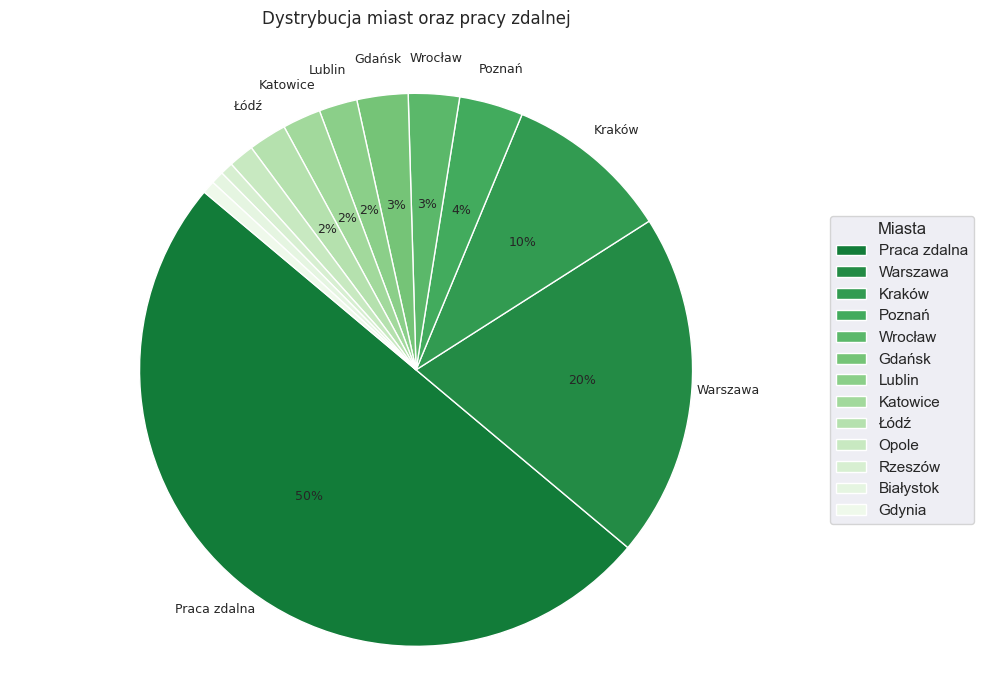

In [33]:
sns.set_theme(style='dark')

n_colors = len(df['location'].explode().unique()) + 2  
colors_full = sns.color_palette('Greens_r', n_colors=n_colors)  

colors = colors_full[2:]

# Tworzenie listy miast
cities = []
for locations in df['location']:
    if isinstance(locations, list):
        cities.extend(locations)
    else:
        cities.append(locations)

# Obliczamy częstotliwość dla każdego miasta
city_counts = Counter(cities)

labels = list(city_counts.keys())
sizes = list(city_counts.values())
labels, sizes = zip(*sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 7))

textprops = {'fontsize': 9, 'fontfamily': 'DejaVu Sans'}
wedgeprops = {'linewidth': 1, 'edgecolor': 'white'}

wedges, texts, autotexts = plt.pie(sizes,
                                   labels=[label if size > 2 else '' for label, size in zip(labels, sizes)],
                                   autopct=lambda pct: f"{int(round(pct))}%" if pct > 2 else '',
                                   startangle=140, colors=colors,
                                   textprops=textprops, wedgeprops=wedgeprops, labeldistance=1.13)
ax.axis('equal')

# Rozmieszczenie tekstu ręcznie dla bardziej równomiernego rozkładu
for text in texts:
    text.set_horizontalalignment('center')
    text.set_verticalalignment("center")

plt.legend(wedges, labels, title="Miasta", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Dystrybucja miast oraz pracy zdalnej', fontname='DejaVu Sans', fontsize=12, loc="center", pad=30)
plt.tight_layout()
plt.show()

Gdzie jest oferowana najwyższa stawka?

In [34]:

df_salary_exploded = df_salary.explode('location')

avg_salary_by_location = df_salary_exploded[df_salary_exploded['location'].apply(lambda x: x in cities)].groupby('location')['average_salary'].mean()

location_with_max_avg_salary = avg_salary_by_location.idxmax()
max_avg_salary = avg_salary_by_location.max()

print(f"Location with the highest average salary: {location_with_max_avg_salary}")
print(f"Average salary: {max_avg_salary.round()}")

Location with the highest average salary: Praca zdalna
Average salary: 22918.0


Jaka jest różnica pomiędzy ofertą dla regular'a a seniora?

In [35]:
average_salary_by_experience = df_salary.groupby('experience level')['average_salary'].mean()

# Ustalenie kolejności poziomów doświadczenia
ordered_experience_levels = ['Junior', 'Mid', 'Senior', 'Expert']

average_salary_by_experience = average_salary_by_experience.reindex(ordered_experience_levels)

print("Average salary by experience level:")
print(average_salary_by_experience.round())

Average salary by experience level:
experience level
Junior    10583.0
Mid       19183.0
Senior    26574.0
Expert    28353.0
Name: average_salary, dtype: float64


In [36]:
# Grupowanie według poziomu doświadczenia i liczby ogłoszeń
count_listings_by_experience = df.groupby('experience level').size()

count_listings_by_experience = count_listings_by_experience.reindex(ordered_experience_levels)

print("Count of listings by experience level:")
print(count_listings_by_experience)

Count of listings by experience level:
experience level
Junior     8
Mid       44
Senior    52
Expert     2
dtype: int64


In [37]:
# Funkcja do zliczania liczby elementów w liście
def count_elements(lst):
    return len(lst)

# Dodanie kolumny z liczbą elementów w 'technology'
df['technology_count'] = df['technology'].apply(count_elements)

# Dodanie kolumny z liczbą elementów w 'nice to have'
df['nice_to_have_count'] = df['nice to have'].apply(count_elements)

# Grupowanie według poziomu doświadczenia i obliczanie średniej liczby elementów w 'technology'
avg_technology_count_by_experience = df.groupby('experience level')['technology_count'].mean()

# Grupowanie według poziomu doświadczenia i obliczanie średniej liczby elementów w 'nice to have'
avg_nice_to_have_count_count_by_experience = df.groupby('experience level')['nice_to_have_count'].mean()

# Uporządkowanie wyników w wymaganym porządku
avg_technology_count_by_experience = avg_technology_count_by_experience.reindex(ordered_experience_levels)

avg_nice_to_have_count_count_by_experience = avg_nice_to_have_count_count_by_experience.reindex(ordered_experience_levels)

print("Average number of elements in technology by experience level:")
print(avg_technology_count_by_experience.round(1))

print("\nAverage number of elements in nice to have by experience level:")
print(avg_nice_to_have_count_count_by_experience.round(1))

Average number of elements in technology by experience level:
experience level
Junior     6.4
Mid        8.1
Senior    10.5
Expert    10.0
Name: technology_count, dtype: float64

Average number of elements in nice to have by experience level:
experience level
Junior    3.4
Mid       3.2
Senior    3.0
Expert    5.0
Name: nice_to_have_count, dtype: float64


In [38]:
cities_per_experience_level = {
    'Junior': Counter(),
    'Mid': Counter(),
    'Senior': Counter(),
    'Expert': Counter()
}

for index, row in df.iterrows():
    experience_level = row['experience level']
    locations = row['location']
    
    if isinstance(locations, list):
        for location in locations:
            cities_per_experience_level[experience_level][location] += 1
    else:
        cities_per_experience_level[experience_level][locations] += 1

print("W których miastach oferowana jest praca specjalistom na różnych poziomach\n")

for experience_level, counter in cities_per_experience_level.items():
    total_unique_cities = len(counter)
    print(f"Total unique cities for {experience_level}: {total_unique_cities}")
    
    # Sortowanie
    sorted_cities = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    
    for city, count in sorted_cities:
        print(f"{city}: {count} {oferta_format(count)}")
    print()


W których miastach oferowana jest praca specjalistom na różnych poziomach

Total unique cities for Junior: 4
Praca zdalna: 5 ofert
Poznań: 1 oferta
Kraków: 1 oferta
Warszawa: 1 oferta

Total unique cities for Mid: 9
Praca zdalna: 28 ofert
Warszawa: 12 ofert
Kraków: 3 oferty
Gdańsk: 2 oferty
Łódź: 2 oferty
Poznań: 1 oferta
Wrocław: 1 oferta
Białystok: 1 oferta
Gdynia: 1 oferta

Total unique cities for Senior: 11
Praca zdalna: 32 oferty
Warszawa: 14 ofert
Kraków: 9 ofert
Wrocław: 3 oferty
Lublin: 3 oferty
Katowice: 3 oferty
Poznań: 3 oferty
Opole: 2 oferty
Gdańsk: 2 oferty
Rzeszów: 1 oferta
Łódź: 1 oferta

Total unique cities for Expert: 1
Praca zdalna: 2 oferty



Jaki jest najniższy możliwy koszt zatrudnienia zespołu złożonego z data analyst, data engineer oraz data scientist?

In [39]:
# Inicjalizacja zmiennej dla całkowitego kosztu zespołu
low_budget_team = 0

for title in df['category'].unique():
    profecional = df_salary.loc[df_salary['category'] == title]['salary_low'].min()
    low_budget_team += profecional
    print(f"Najtańszy {title.title()} kosztuje: {profecional}")
    
print(f"Koszt zespołu: {low_budget_team}")


Najtańszy Data Analyst kosztuje: 5500.0
Najtańszy Data Engineer kosztuje: 7000.0
Najtańszy Data Scientist kosztuje: 7100.0
Koszt zespołu: 19600.0


Czy istnieje możliwość powołania zespołu w jednym mieście? Jeśli tak to gdzie by było najtaniej?

In [40]:
# Tworzenie listy unikalnych kategorii i miast
categories = df['category'].unique()
cities = set(city for loc in df_salary['location'] for city in (loc if isinstance(loc, list) else [loc]))

# Inicjalizacja słownika do przechowywania całkowitego kosztu zespołu w każdym mieście
city_team_costs = defaultdict(float)

# Iteracja przez każde miasto
for city in cities:
    total_cost = 0
    valid_team = True
    
    # Iteracja przez każdą kategorię
    for category in categories:
        # Znalezienie najniższej pensji wśród profesjonalistów w podzbiorze df_salary dla bieżącej kategorii i miasta
        lowest_salary = df_salary.loc[
            (df_salary['category'] == category) & 
            (df_salary['location'].apply(lambda x: city in x if isinstance(x, list) else city == x))
        ]['salary_low'].min()
        
        # Sprawdzenie, czy znaleziono pensję dla bieżącej kategorii w tym mieście
        if pd.isna(lowest_salary):
            valid_team = False
            break
        total_cost += lowest_salary
    
    if valid_team:
        city_team_costs[city] = total_cost

# Sortowanie miast według całkowitego kosztu zespołu
sorted_city_team_costs = sorted(city_team_costs.items(), key=lambda item: item[1])

# Znalezienie najtańszych miast
if len(sorted_city_team_costs) > 0:
    cheapest_city = sorted_city_team_costs[0]
    print(f"Najtańszy zespół można powołać w mieście {cheapest_city[0]}, a jego koszt wynosi {cheapest_city[1]}")
    if len(sorted_city_team_costs) > 1:
        second_cheapest_city = sorted_city_team_costs[1]
        print(f"Drugi najtańszy zespół można powołać w mieście {second_cheapest_city[0]}, a jego koszt wynosi {second_cheapest_city[1]}")
    if len(sorted_city_team_costs) > 2:
        third_cheapest_city = sorted_city_team_costs[2]
        print(f"Trzeci najtańszy zespół można powołać w mieście {third_cheapest_city[0]}, a jego koszt wynosi {third_cheapest_city[1]}")
else:
    print("Nie można powołać zespołu w jednym mieście.")



Najtańszy zespół można powołać w mieście Warszawa, a jego koszt wynosi 29100.0
Drugi najtańszy zespół można powołać w mieście Praca zdalna, a jego koszt wynosi 29120.0
Trzeci najtańszy zespół można powołać w mieście Kraków, a jego koszt wynosi 45200.0


Jak dużo ogłoszeń wymaga znajomości języka angielskiego?

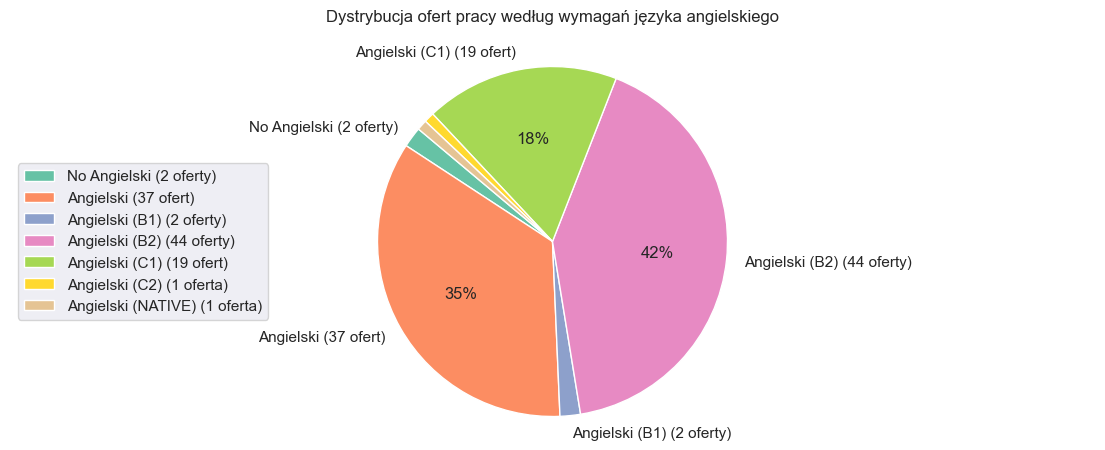

In [41]:
# Funkcja do zliczania liczby ogłoszeń dla różnych poziomów znajomości języka angielskiego
def count_ads_by_english_level(row):
    technology = row['technology']
    if not isinstance(technology, list):
        return {'No Angielski': 1, 'Angielski': 0, 'Angielski (B1)': 0, 'Angielski (B2)': 0, 
                'Angielski (C1)': 0, 'Angielski (C2)': 0, 'Angielski (NATIVE)': 0}
    
    has_angielski = False
    has_angielski_b1 = False
    has_angielski_b2 = False
    has_angielski_c1 = False
    has_angielski_c2 = False
    has_angielski_native = False
    
    for tech in technology:
        if tech == 'Angielski':
            has_angielski = True
        elif tech == 'Angielski (B1)':
            has_angielski_b1 = True
        elif tech == 'Angielski (B2)':
            has_angielski_b2 = True
        elif tech == 'Angielski (C1)':
            has_angielski_c1 = True
        elif tech == 'Angielski (C2)':
            has_angielski_c2 = True
        elif tech == 'Angielski (NATIVE)':
            has_angielski_native = True
    
    return {'No Angielski': 0 if any([has_angielski, has_angielski_b1, has_angielski_b2, has_angielski_c1, has_angielski_c2, has_angielski_native]) else 1,
            'Angielski': 1 if has_angielski else 0,
            'Angielski (B1)': 1 if has_angielski_b1 else 0,
            'Angielski (B2)': 1 if has_angielski_b2 else 0,
            'Angielski (C1)': 1 if has_angielski_c1 else 0,
            'Angielski (C2)': 1 if has_angielski_c2 else 0,
            'Angielski (NATIVE)': 1 if has_angielski_native else 0}

# Dodanie kolumny z liczbą ogłoszeń dla różnych poziomów znajomości języka angielskiego
df_counts = pd.DataFrame(df.apply(count_ads_by_english_level, axis=1).tolist())

# Zliczanie sumarycznych wartości dla każdego poziomu znajomości języka angielskiego
totals = df_counts.sum()

labels = totals.index
sizes = totals.values

colors = sns.color_palette("Set2")

plt.figure(figsize=(14, 5))
patches, texts, autotexts = plt.pie(sizes, labels=[f"{label} ({size} {oferta_format(size)})" if size >= 2 else '' for label, size in zip(labels, sizes)], 
                                    autopct=lambda pct: f"{int(round(pct))}%" if pct >= 2 else '', startangle=140, colors=colors)

legend_labels = [f"{label} ({size} {oferta_format(size)})" for label, size in zip(labels, sizes)]
plt.legend(handles=patches, labels=legend_labels, loc="lower right")

plt.title('Dystrybucja ofert pracy według wymagań języka angielskiego', pad=20)
plt.axis('equal')
plt.legend(handles=patches, labels=legend_labels, loc="center left")
plt.show()

Grafiki zapotrzebowania i wynagrodzenia

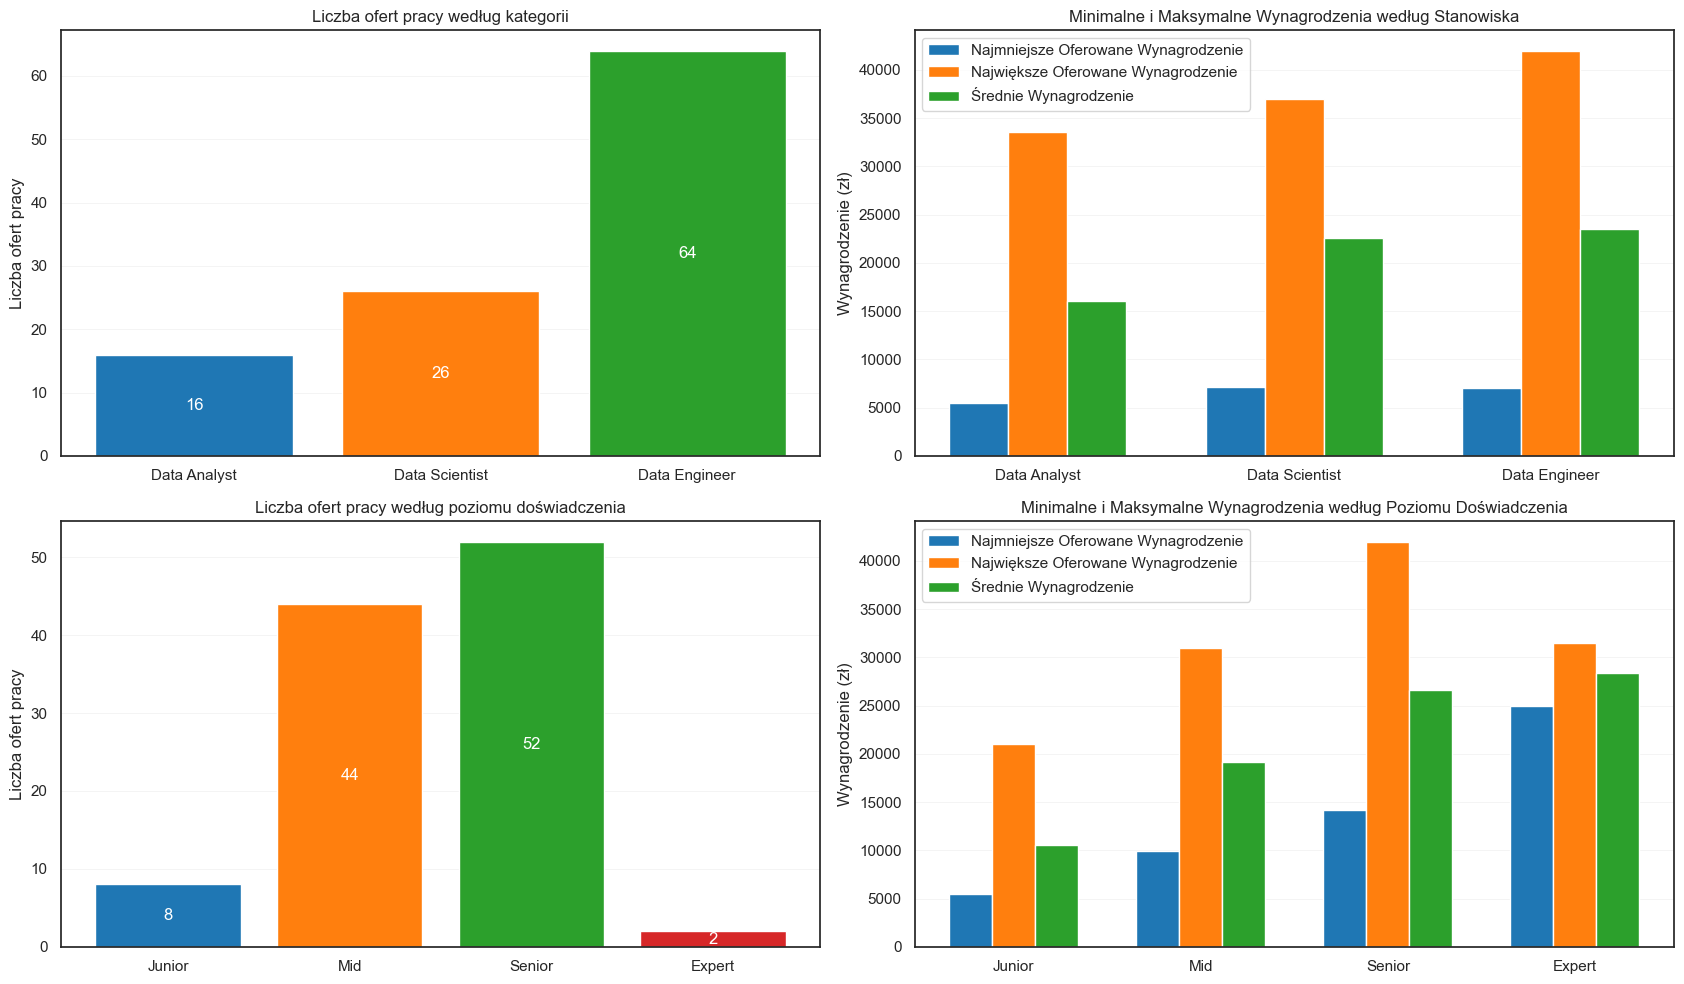

In [42]:
sns.set_theme(style="white", palette="tab10", font='sans-serif')
# 1 Wykres z liczbą ofert pracy według kategorii
fig, axs = plt.subplots(2, 2, figsize=(17, 10))

# 1 podwykres: Wykres słupkowy z liczbą ofert pracy według kategorii
categories = ['analyst', 'scientist', 'engineer']
counts = []

for category in categories:
    count_data = df[df['category'] == f'data {category}'].shape[0]
    counts.append(count_data)

colors = sns.color_palette("tab10")  # kolory dla słupków
bars = axs[0, 0].bar([f'Data {category.capitalize()}' for category in categories], counts, color=colors)

# Dodanie wartości do słupków
for bar in bars:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width() / 2, yval / 2, int(yval), ha='center', va='center', color='white')

axs[0, 0].set_title('Liczba ofert pracy według kategorii')
axs[0, 0].set_ylabel('Liczba ofert pracy')

# 2 i 4 podwykres: Wykres słupkowy z minimalnymi i maksymalnymi wynagrodzeniami według kategorii
# Filtracja wynagrodzeń poniżej 1000
df_salary = df[df['average_salary'] >= 1000]

# Grupowanie danych według kategorii
grouped_job_title = df_salary.groupby('category').agg({'salary_low': 'min', 'salary_high': 'max', 'average_salary': 'mean'}).reindex(['data analyst', 'data scientist', 'data engineer']).reset_index()
grouped_experience_level = df_salary.groupby('experience level').agg({'salary_low': 'min', 'salary_high': 'max', 'average_salary': 'mean'}).reindex(['Junior', 'Mid', 'Senior', 'Expert']).reset_index()

# Budowanie wykresów

# Wykres według stanowiska
width = 0.23
positions = range(len(grouped_job_title))

axs[0, 1].bar([p - width for p in positions], grouped_job_title['salary_low'], width=width, label='Najmniejsze Oferowane Wynagrodzenie')
axs[0, 1].bar(positions, grouped_job_title['salary_high'], width=width, label='Największe Oferowane Wynagrodzenie')
axs[0, 1].bar([p + width for p in positions], grouped_job_title['average_salary'], width=width, label='Średnie Wynagrodzenie')

axs[0, 1].set_ylabel('Wynagrodzenie (zł)')
axs[0, 1].set_title('Minimalne i Maksymalne Wynagrodzenia według Stanowiska')
axs[0, 1].set_xticks(positions)
axs[0, 1].set_xticklabels(grouped_job_title['category'])
axs[0, 1].set_xticklabels(['Data Analyst', 'Data Scientist', 'Data Engineer'])
axs[0, 1].legend()

# Wykres minimalnych i maksymalnych wynagrodzeń według poziomu doświadczenia

positions = range(len(grouped_experience_level))

axs[1, 1].bar([p - width for p in positions], grouped_experience_level['salary_low'], width=width, label='Najmniejsze Oferowane Wynagrodzenie')
axs[1, 1].bar(positions, grouped_experience_level['salary_high'], width=width, label='Największe Oferowane Wynagrodzenie')
axs[1, 1].bar([p + width for p in positions], grouped_experience_level['average_salary'], width=width, label='Średnie Wynagrodzenie')

axs[1, 1].set_ylabel('Wynagrodzenie (zł)')
axs[1, 1].set_title('Minimalne i Maksymalne Wynagrodzenia według Poziomu Doświadczenia')
axs[1, 1].set_xticks(positions)
axs[1, 1].set_xticklabels(grouped_experience_level['experience level'])
axs[1, 1].legend()

# 3 podwykres: Wykres słupkowy z liczbą ofert pracy według poziomu doświadczenia
levels = ['Junior', 'Mid', 'Senior', 'Expert']
counts_levels = []

for level in levels:
    count_data = df[df['experience level'] == level].shape[0]
    counts_levels.append(count_data)

colors_levels = sns.color_palette("tab10")
# kolory dla słupków
bars_levels = axs[1, 0].bar(levels, counts_levels, color=colors_levels)

# Dodanie wartości do słupków dla poziomów doświadczenia
for bar in bars_levels:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width() / 2, yval / 2, int(yval), ha='center', va='center', color='white')

axs[1, 0].set_title('Liczba ofert pracy według poziomu doświadczenia')
axs[1, 0].set_ylabel('Liczba ofert pracy')

for i in range(2):
    for j in range(2):
        axs[i, j].grid(axis='y', linewidth=0.5, alpha=0.3)
        axs[i, j].set_axisbelow(True)

plt.tight_layout()
plt.show()

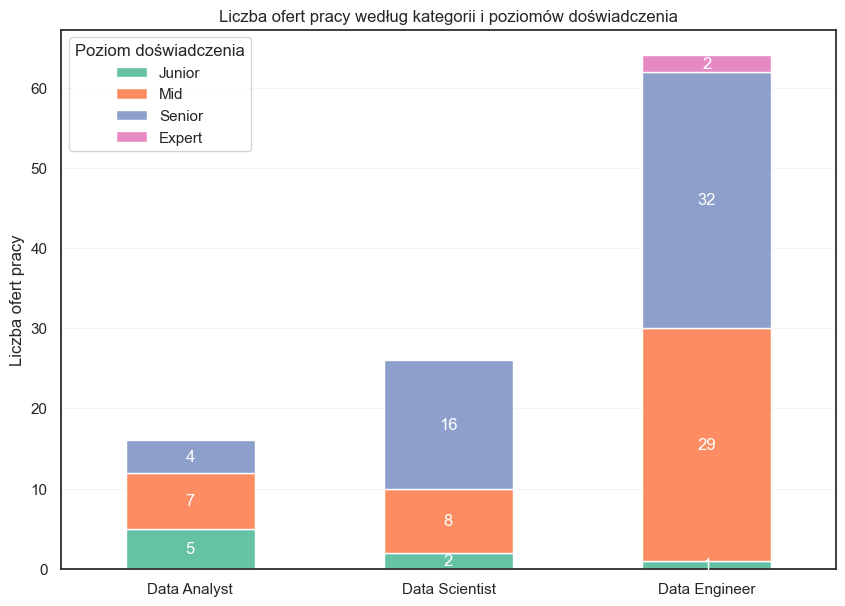

In [43]:
sns.set_theme(style="white", palette="Set2")

# Filtracja kategorii i poziomów doświadczenia
categories = ['data analyst', 'data scientist', 'data engineer']
experience_levels = ['Junior', 'Mid', 'Senior', 'Expert']

df_plot = df[df['category'].isin(categories)]

# Obliczenie liczby ofert pracy według kategorii i poziomów doświadczenia
offers_count = df_plot.groupby(['category', 'experience level']).size().unstack(fill_value=0)
offers_count = offers_count[experience_levels]

# Zapewnienie poprawnej kolejności kategorii
offers_count = offers_count.loc[categories]

fig, ax = plt.subplots(figsize=(10, 7))

offers_count.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette("Set2"))

# Dodanie wartości liczbowych nad każdym słupkiem
for i in range(len(offers_count.index)):
    for j in range(len(offers_count.columns)):
        count = offers_count.iloc[i, j]
        if count > 0:
            ax.text(i, offers_count.iloc[i, :j+1].sum() - count / 2, str(count), ha='center', va='center', color='white')

plt.grid(axis='y', linewidth=0.5, alpha=0.3)
ax.set_axisbelow(True)
plt.title('Liczba ofert pracy według kategorii i poziomów doświadczenia')
plt.xlabel("")
plt.ylabel('Liczba ofert pracy')
plt.legend(title='Poziom doświadczenia')
plt.xticks(range(len(categories)), [category.title() for category in categories], rotation=0)
plt.show()



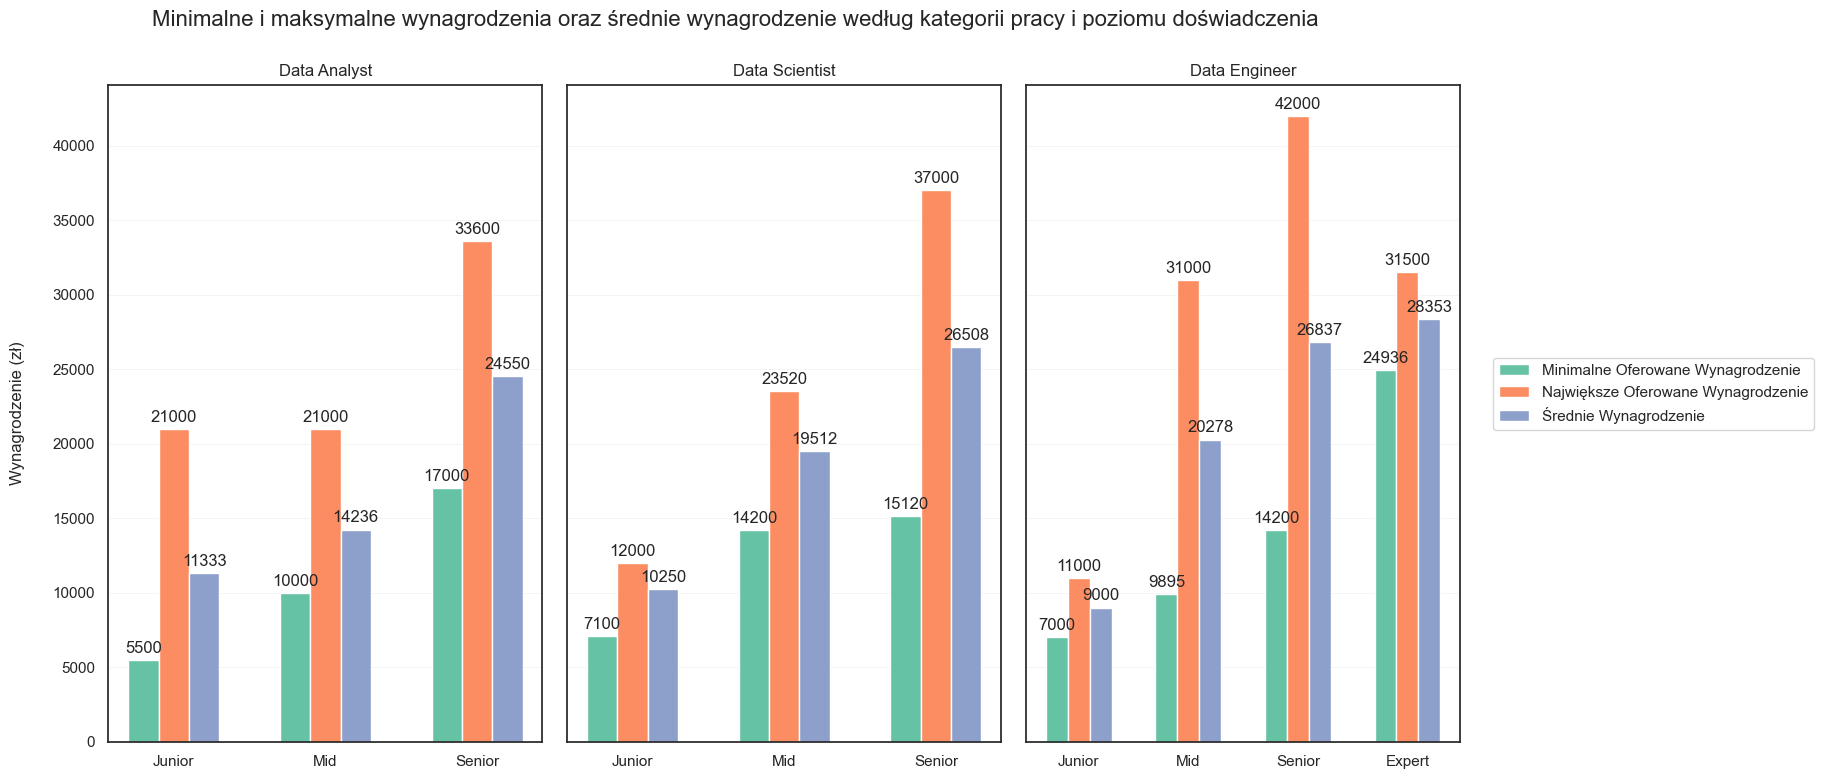

In [44]:
sns.set_theme(style="white", palette="Set2")

# Filtracja kategorii i poziomów doświadczenia
categories = ['data analyst', 'data scientist', 'data engineer']
experience_levels = ['Junior', 'Mid', 'Senior', 'Expert']

df_plot = df_salary[df_salary['category'].isin(categories)]

# Pobranie minimalnego, maksymalnego wynagrodzenia i średniego wynagrodzenia dla każdej kategorii i poziomu doświadczenia
grouped_job_title = df_plot.groupby(['category', 'experience level']).agg({'salary_low': 'min', 'salary_high': 'max', 'average_salary': 'mean'}).reindex(categories, level=0).reset_index()

# Ustawienie odpowiedniej kolejności kategorii
grouped_job_title = grouped_job_title.set_index(['category', 'experience level']).reindex(pd.MultiIndex.from_product([categories, experience_levels], names=['category', 'experience level'])).reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
width = 0.2

# Iteracja po każdej kategorii i tworzenie wykresu dla każdego subplotu
for i, category in enumerate(categories):
    positions = range(len(experience_levels))
    ax = axs[i]

    # Dodanie słupków dla minimalnego, maksymalnego i średniego wynagrodzenia
    bars = []
    bars.append(ax.bar([p - width for p in positions], grouped_job_title.loc[grouped_job_title['category'] == category, 'salary_low'], width=width, label='Minimalne Oferowane Wynagrodzenie'))
    bars.append(ax.bar(positions, grouped_job_title.loc[grouped_job_title['category'] == category, 'salary_high'], width=width, label='Największe Oferowane Wynagrodzenie'))
    bars.append(ax.bar([p + width for p in positions], grouped_job_title.loc[grouped_job_title['category'] == category, 'average_salary'], width=width, label='Średnie Wynagrodzenie'))

    # Dodanie wartości na słupkach
    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            if isinstance(height, (float, int)) and not np.isnan(height):
                ax.annotate('{}'.format(int(height)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

    ax.set_title(f'{category.title()}')

    # Ustawienie mitek tylko dla poziomów doświadczenia z wartościami
    valid_positions = [p for p in positions if not grouped_job_title.loc[(grouped_job_title['category'] == category) & (grouped_job_title['experience level'] == experience_levels[p]), 'salary_low'].isna().all()]
    valid_labels = [experience_levels[p] for p in valid_positions]
    ax.set_xticks(valid_positions)
    ax.set_xticklabels(valid_labels)

# Dodanie wspólnej legendy
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Dodanie siatki do wykresów
for ax in axs:
    ax.grid(axis='y', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)

# Dodanie tytułu głównego i wyświetlenie wykresów
axs[0].set_ylabel('Wynagrodzenie (zł)', labelpad=20)
fig.suptitle('Minimalne i maksymalne wynagrodzenia oraz średnie wynagrodzenie według kategorii pracy i poziomu doświadczenia', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1], pad=1.5)
plt.show()

Top 10 narzędzi dla każdej z kategorii

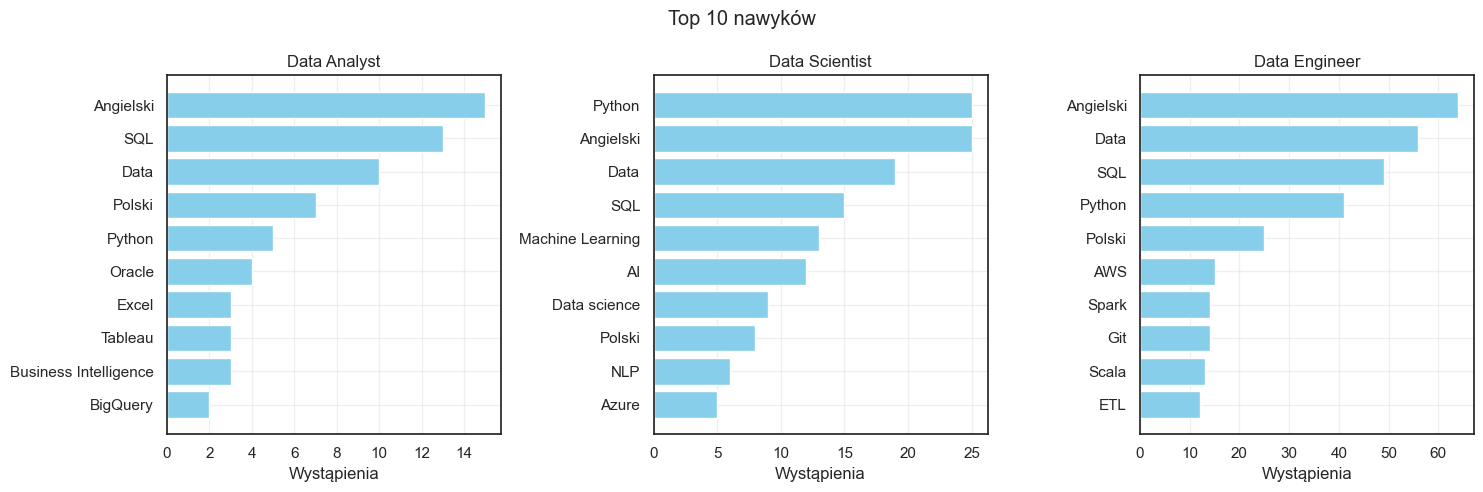

Liczba technologii w Data Analyst:
Counter({'Angielski': 15, 'SQL': 13, 'Data': 10, 'Polski': 7, 'Python': 5, 'Oracle': 4, 'Excel': 3, 'Tableau': 3, 'Business Intelligence': 3, 'BigQuery': 2, 'ETL': 2, 'Communication skills': 2, 'Business Analysis': 2, 'Zaangażowanie': 1, 'Power BI': 1, 'Samodzielność': 1, 'Odpowiedzialność': 1, 'Backend': 1, 'Google Data Studio': 1, 'Node.js': 1, 'Git': 1, 'Linux': 1, 'Data base': 1, 'CRM': 1, 'Microsoft SQL Server': 1, 'SAP': 1, 'Problem solving': 1, 'Critical thinking': 1, 'Google Analytics': 1, 'A/B Testing': 1, 'Snowflake': 1, 'Redshift': 1, 'R': 1, 'Looker': 1, 'Shiny': 1, 'Finanse': 1, 'Accounting': 1, 'Management Reporting': 1, 'Reporting': 1, 'Audit': 1, 'Analytical skills': 1, 'PowerPoint': 1, 'BSc': 1, 'MSc': 1, 'Degree': 1})

Liczba technologii w Data Scientist:
Counter({'Python': 25, 'Angielski': 25, 'Data': 19, 'SQL': 15, 'Machine Learning': 13, 'AI': 12, 'Data science': 9, 'Polski': 8, 'NLP': 6, 'Azure': 5, 'Deep learning': 5, 'Communica

In [45]:
# Funkcja do zliczania technologii
def count_technologies(tech_lists):
    technology_counts = Counter()
    original_names = {}
    
    for tech_list in tech_lists:
        for tech in tech_list:
            # Konwersja tech na małe litery w celu uwzględnienia wielkości liter
            tech_lower = tech.lower()
            
            # Uproszczenie nazw technologii przez łączenie różnych wariantów
            if 'angielski' in tech_lower:
                simplified_tech = 'angielski'
                original_names[simplified_tech] = 'Angielski'
            elif 'polski' in tech_lower:
                simplified_tech = 'polski'
                original_names[simplified_tech] = 'Polski'
            elif tech_lower in ['ai', 'openai', 'genai'] or 'openai' in tech_lower or 'genai' in tech_lower:
                simplified_tech = 'ai'
                original_names[simplified_tech] = 'AI'
            elif 'powerbi' in tech_lower or 'power bi' in tech_lower:
                simplified_tech = 'power bi'
                original_names[simplified_tech] = 'Power BI'
            elif 'ms excel' in tech_lower or 'excel' in tech_lower:
                simplified_tech = 'excel'
                original_names[simplified_tech] = 'Excel'
            elif 'oracle database' in tech_lower or 'oracle' in tech_lower:
                simplified_tech = 'oracle'
                original_names[simplified_tech] = 'Oracle'
            elif 'a/b testing' in tech_lower or 'testing' in tech_lower:
                simplified_tech = 'a/b testing'
                original_names[simplified_tech] = 'A/B Testing'
            elif 'bi' == tech_lower or 'business intelligence' in tech_lower:
                simplified_tech = 'business intelligence'
                original_names[simplified_tech] = 'Business Intelligence'
            elif 'airflow' in tech_lower or 'apache airflow' in tech_lower:
                simplified_tech = 'airflow'
                original_names[simplified_tech] = 'Airflow'
            elif tech_lower in ['microsoft sql server', 'ms sql', 't-sql', 'transact-sql', 'sql server']:
                simplified_tech = 'microsoft sql server'
                original_names[simplified_tech] = 'Microsoft SQL Server'
            else:
                simplified_tech = tech_lower
                original_names[simplified_tech] = tech
            
            # Dodanie do licznika
            technology_counts[simplified_tech] += 1
    
    # Przekształcenie liczników z zachowaniem oryginalnych nazw
    final_counts = Counter({original_names[tech]: count for tech, count in technology_counts.items()})
    
    return final_counts

categories = ["data analyst", "data scientist", "data engineer"]

fig, axs = plt.subplots(1, len(categories), figsize=(15, 5))

for i, category in enumerate(categories):
    tech_lists = df[df['category'] == category]['technology']
    tech_counts = count_technologies(tech_lists)
    top_technologies = tech_counts.most_common(10)
    top_technologies_names = [tech[0] for tech in top_technologies]
    top_technologies_counts = [tech[1] for tech in top_technologies]

    axs[i].barh(top_technologies_names, top_technologies_counts, color='skyblue')
    axs[i].set_title(category.title())
    axs[i].set_xlabel('Wystąpienia')
    axs[i].invert_yaxis()
    axs[i].grid(linewidth=1, alpha=0.3)
    axs[i].set_axisbelow(True)
    fig.suptitle('Top 10 nawyków')

    # Ustawianie wartości osi x na liczby całkowite dla kategorii Data Analyst
    if category == 'data analyst':
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# Iteracja przez kategorie i wyświetlanie liczników
for category in categories:
    tech_lists = df[df['category'] == category]['technology']
    tech_counts = count_technologies(tech_lists)
    print(f'Liczba technologii w {category.title()}:')
    print(tech_counts)
    print()

Gdzie potrzebują Juniorów?

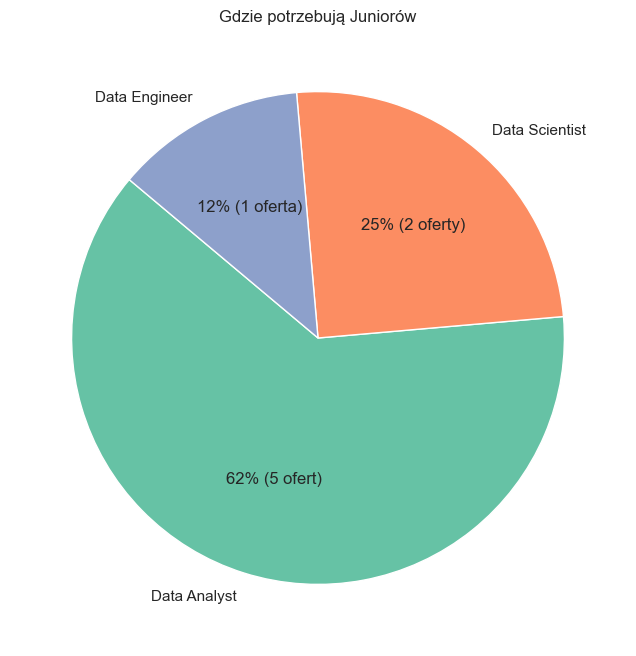

In [46]:
# Filtrowanie danych dla poziomu doświadczenia Junior
df_junior = df[df['experience level'] == 'Junior']

# Grupowanie danych według nazwy stanowiska dla poziomu Junior
junior_job_counts = df_junior['category'].value_counts()

# Funkcja do formatowania etykiet
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.0f}% ({val} {oferta_format(val)})'
    return my_format

plt.figure(figsize=(8, 8))
plt.pie(junior_job_counts, labels=[i.title() for i in junior_job_counts.index], autopct=autopct_format(junior_job_counts), startangle=140)
plt.title('Gdzie potrzebują Juniorów')
plt.show()


Wniosek

• Największe zapotrzebowanie na specjalistów na poziomie Junior jest głównie w branży Data Analysis (5 ofert), rzadziej w Data Science (2 oferty), a najrzadziej w Data Engineering (1 oferta).

• Oferty z najwyższymi możliwymi zarobkami (powyżej 40 tys. zł) są skierowane do Data Inżynierów na poziomie Senior.

• Najmniejsze oferowane wynagrodzenia dla Data Scientistów i Data Inżynierów są zbliżone (około 7 tys. zł), jednak średnie wynagrodzenie dla Data Inżynierów jest nieco wyższe.

• Spośród najniższych oferowanych wynagrodzeń, według poziomu doświadczenia, najwyższe jest dla Ekspertów. To oznacza, że osoby na tym poziomie doświadczenia nie znajdą ofert wynagrodzenia niższych niż 24 936 zł.

• Największy udział ogłoszeń (50%) miejscem lokalizacji zaznacza pracę zdalną, druga najpopularniejsza lokalizacja to Warszawa (20%) i razem one składają 70% wszystkich ofert na rynku pracy.

• Tylko 2 oferty (około 2% od wszystkich ofert pracy) nie wymagają znajomości języka angielskiego.

• Największy odsetek ogłoszeń (42%) wymaga znajomości języka angielskiego co najmniej na poziomie B2.